<a href="https://colab.research.google.com/github/ItsnotMax/Lola/blob/main/%D0%9B%D0%BE%D0%BB%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
!pip install icrawler
from icrawler.builtin import BingImageCrawler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import chain
from zipfile import ZipFile
from PIL import Image
from fastai.vision.all import *

from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.naive_bayes import GaussianNB

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim

from skimage import data, io
from skimage.feature import hog
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import unsharp_mask
from skimage.transform import resize, rescale

In [202]:
parser = False
google_disk = True
path = '/content/drive/MyDrive/MyProjects/Lola_class/'

def image_downloader (folder, filters_dict, num_picture, path_folder):
  bing_crawler = BingImageCrawler(
      downloader_threads=4,
      storage={'root_dir': path_folder}
      )
  bing_crawler.crawl(keyword=folder, filters=filters_dict, offset=0, max_num=num_picture)

if parser:
  filters_dict = dict(
      type='photo',
      size='medium',
      color='color',
      license='noncommercial'
      )

  input_cat = input ('Введите интересующие вас категории через запятую и нажмите Enter: ').split (', ')
  num_picture = int (input ('Введите количетсво скачиваемых фотографий в каждой категории: '))
  print ('Использую GoogleImageCrawler:')
  print (f'Используемые фильтры: {filters_dict}')
  print (f'Загружаю фотографии категорий: {input_cat} на Google Disk')
  for folder in input_cat:
    if not folder in os.listdir():
      os.mkdir(path + folder)
    path_folder = path + folder
    image_downloader (folder, filters_dict, num_picture, path_folder)

if google_disk:
  print ('Подключаю Google Disk____________________нажмите "Подключиться"')
  from google.colab import drive
  drive.mount('/content/drive')


Подключаю Google Disk____________________нажмите "Подключиться"
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.304448,0.701732,0.287500,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.894376,0.786272,0.337500,00:23
1,0.823296,0.735174,0.287500,00:23
2,0.800051,0.741170,0.250000,00:22
3,0.748206,0.713490,0.212500,00:25
4,0.690516,0.682838,0.175000,00:22
5,0.650887,0.562477,0.162500,00:23
6,0.605707,0.523004,0.150000,00:23


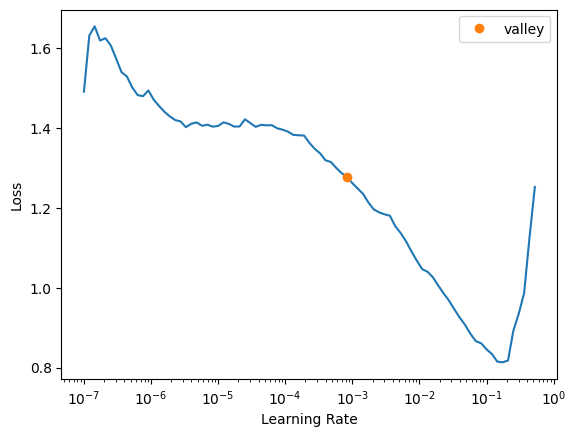

In [203]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
kwargs = {
    'num_workers': 4,
    'pin_memory': True,
    'device': device
    } if torch.cuda.is_available() else {}

batch_size = 64
resize_photo = (320,320)

nvidia_info = False
if nvidia_info:
  !nvidia-smi

Lola = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.15),
    get_y=parent_label,
    item_tfms=Resize(resize_photo, method='crop'),
    batch_tfms=aug_transforms(mult=2.0, min_scale=0.9)
)

Lola_loaders = Lola.dataloaders(
    path,
    bs=batch_size,
    **kwargs
    )

model_cnn = vision_learner (
    Lola_loaders,
    resnet18,
    metrics = error_rate
    )

learning_rate = model_cnn.lr_find()
model_cnn.fine_tune (7, base_lr = learning_rate[0])

In [204]:
# print (get_image_files (path))
# print (Lola_loaders.vocab) ### Показать категории
# print (Lola.summary(path))
# Lola_loaders.show_batch (max_n=5, figsize=(12,10))
# interp = ClassificationInterpretation.from_learner (model_cnn)
# interp.plot_confusion_matrix ()
# interp.plot_top_losses(10, nrows=2)
# #plt.plot(L(model_cnn.recorder.values).itemgot(1))
# #model_cnn.recorder.plot()

In [205]:
Lola_face_path = '/content/drive/MyDrive/MyProjects/LolasFace/'
imgs_to_extract_neg_feature = [getattr(data, name)() for name in ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'coffee', 'astronaut']]
resize_img = (128,128)
max_negative_patches = 50
scale = 1.0
hog_param = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'visualize': False,
    'block_norm': 'L2'
}

def positive_batch_prep (path_pos_img = Lola_face_path, img_size = resize_img ):
  photo_collection_name = [Lola_face_path + img_name for img_name in os.listdir(Lola_face_path)]
  photo_collection_open = io.imread_collection (photo_collection_name, conserve_memory = True)
  photo_collection_resize = [unsharp_mask (resize (img, img_size, anti_aliasing=True), radius=10, amount=2, channel_axis=2) for img in photo_collection_open]
  photo_collection_gray = [rgb2gray (img) for img in photo_collection_resize]
  normalize_photo = [Normalizer().fit_transform (img) for img in photo_collection_gray]
  return normalize_photo

def negative_batch_prep (neg_batch = imgs_to_extract_neg_feature, max_patches = max_negative_patches, scale = scale, img_size = resize_img):
  extracted_img_size = (int(img_size[0]*scale), int(img_size[1]*scale))
  extractor = PatchExtractor (patch_size = extracted_img_size, max_patches=max_patches)
  patches = np.vstack ([extractor.transform (img[np.newaxis]) if len (img.shape) < 3 else (extractor.transform (rgb2gray (img)[np.newaxis])) for img in neg_batch])
  neg_batch_gray = [rgb2gray (img) if len (img.shape) > 2 else img for img in patches]
  normalize_photo = [Normalizer().fit_transform (img) for img in neg_batch_gray]
  return normalize_photo

def train_hog (positive_batch, negative_batch):
  train_batch = [img for img in chain (positive_batch, negative_batch)]
  X_train = [hog(batch, **hog_param) for batch in train_batch]
  y_train = np.zeros (np.asarray (train_batch).shape[0])
  y_train [:np.asarray (positive_batch).shape[0]] = 1
  return X_train, y_train

positive_batch = positive_batch_prep ()
negative_batch = negative_batch_prep ()
X_train_hog, y_train_hog = train_hog (positive_batch, negative_batch)

model_hog = GaussianNB()
model_hog.fit (X_train_hog, y_train_hog)

GaussianNB()

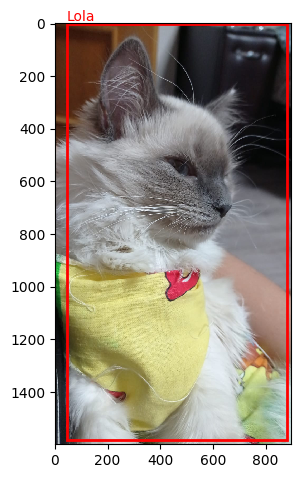

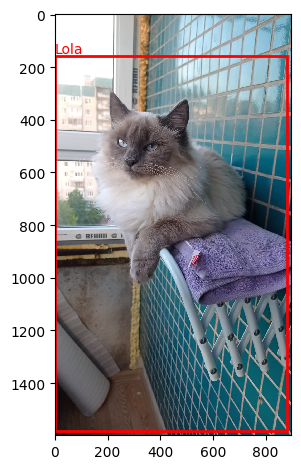

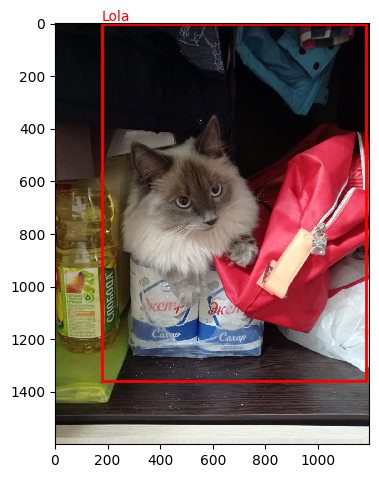

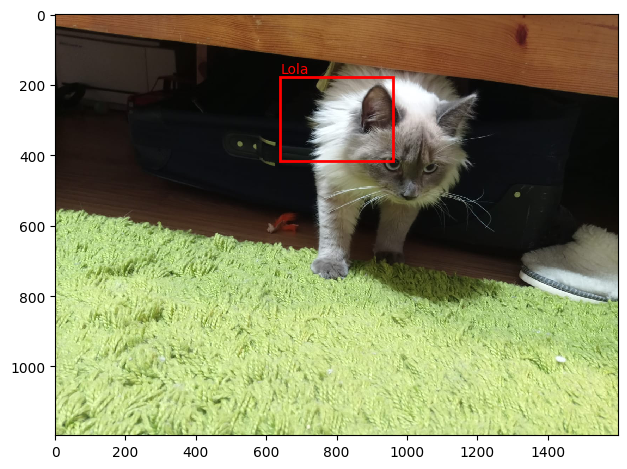

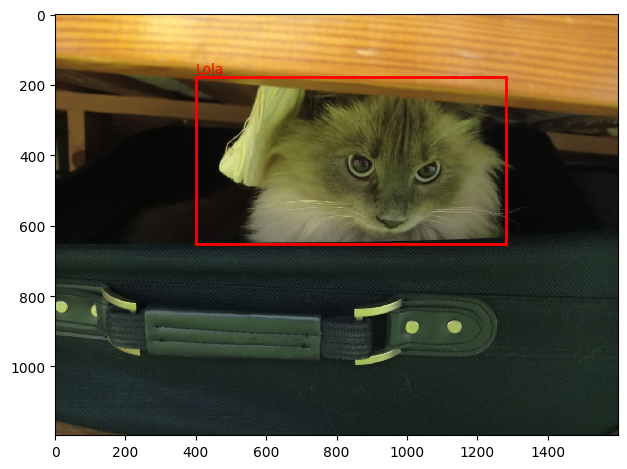

In [212]:
# predict Лолы и ее мордочки
from google.colab import files
uploaded_learning = files.upload()
learning_file = list(uploaded_learning.keys())[0]
data_r = ZipFile(learning_file, 'r')
data_r.extractall(path=None, members=None, pwd=None)
name_list_for_pred = data_r.namelist()

def slide_box (img):
  h_slide_box = int (img.shape[0]/5)
  w_slide_box = int (img.shape[1]/5)
  h_step = int (h_slide_box/4)
  w_step = int (w_slide_box/4)
  for i in range (0, img.shape[0] - h_slide_box+1, h_step):
    for j in range (0, img.shape[1] - w_slide_box+1, w_step):
      patch = img [i : i+h_slide_box, j : j+w_slide_box]
      yield (i, j), patch, h_slide_box, w_slide_box

def predict_hog (indices, patches, positive_batch = positive_batch, hog_param = hog_param, resize_img=resize_img, model = model_hog):
  trusted_indices = []
  trusted_patch = []
  confidential_feature_min, confidential_feature_max = (np.mean(positive_batch) - np.std(positive_batch), np.mean(positive_batch) + np.std(positive_batch))
  for idx, patch in enumerate (patches):
    if np.mean (patch) >= confidential_feature_min*0.8 and np.mean (patch) <= confidential_feature_max*1.2:
      trusted_patch.append (hog(resize (patch, resize_img), **hog_param))
      trusted_indices.append (indices [idx])
  if len (trusted_patch):
    return trusted_indices, model.predict (trusted_patch)
  else:
    ask = []*len (trusted_indices)
    return trusted_indices, ask

def predict (name_list_for_pred = name_list_for_pred, model = model_cnn):
  collection_for_predict = io.imread_collection (name_list_for_pred, conserve_memory = True)
  predicted = [model_cnn.predict (img)[0] for img in collection_for_predict]
  for idx, pred in enumerate (predicted):
    if pred == 'Lola':
      original_img = collection_for_predict[idx]
      filtered_img = Normalizer().fit_transform (unsharp_mask (rgb2gray(original_img), radius=10, amount=2))
      indices, patches, h_slide_box, w_slide_box = zip (*slide_box (filtered_img))
      indices, labels = predict_hog (indices, patches)
      if len (labels):
        io.imshow(original_img)
        indices = np.asarray (indices)
        x_0 = indices [labels==1][:, 1].min()
        y_0 = indices [labels==1][:, 0].min()
        x_1 = indices [labels==1][:, 1].max() - indices [labels==1][:, 1].min() + w_slide_box[0]
        y_1 = indices [labels==1][:, 0].max() - indices [labels==1][:, 0].min() + h_slide_box[0]
        plt.gca ().add_patch(Rectangle((x_0, y_0), x_1, y_1,  edgecolor='red', alpha = 1, lw=2, facecolor='none'))
        plt.text (x_0, y_0-10, 'Lola', color = 'red', fontsize='medium')
        plt.show()
      else:
        io.imshow(original_img)
        plt.text (original_img.shape[0]/4, original_img.shape[1]/2, 'Я НЕ НАШЕЛ ЛОЛУ', color = 'red', fontsize='large')
        plt.show()

predict ()